Souna Niang

Ousmane Kontao

Oumar Talibe BA

# TP04 MapReduce - Multiplication Matricielle
# Matrice A et B chargées par lignes et colonnes

## Chargement des matrices A et B

In [53]:
import numpy as np
import time
import threading
import matplotlib.pyplot as plt
import pandas as pd

## Chargement des fichiers lignes et colonnes

In [17]:
A_data = np.load("A.npz")
B_data = np.load("B.npz")

In [18]:
A_data['row_0']

array([7, 8, 9, ..., 9, 8, 9])

## Reconstruction de A et B à partir des lignes et colonnes

In [19]:
%%time
A = np.vstack([A_data[f"row_{i}"] for i in range(len(A_data.files))])
B = np.vstack([B_data[f"col_{j}"] for j in range(len(B_data.files))]).transpose()

CPU times: user 35.7 ms, sys: 24.1 ms, total: 59.8 ms
Wall time: 58.8 ms


In [20]:
# Vérification des dimensions
print(f"Matrice A reconstruite : {A.shape}")
print(f"Matrice B reconstruite : {B.shape}")

Matrice A reconstruite : (100, 10000)
Matrice B reconstruite : (10000, 100)


## Multiplication avec NumPy

In [21]:
%time C = A @ B
print("Multiplication terminée avec succès.")

CPU times: user 90.4 ms, sys: 2.39 ms, total: 92.8 ms
Wall time: 92.2 ms
Multiplication terminée avec succès.


In [22]:
A = np.load("../TP04_02_01_MM/A.npy")
B = np.load("../TP04_02_01_MM/B.npy")

# Affichage des dimensions pour vérification
print(f"Matrice A : {A.shape}")
print(f"Matrice B : {B.shape}")

Matrice A : (100, 10000)
Matrice B : (10000, 100)


In [23]:
%%time
C_numpy = A @ B

CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 184 ms


## Questions

1. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **multithreading** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$ en ne chargeant que les lignes et les colonnes nécessaires.

Dans la première partie du TP, nous avons chargé les matrices A et B entièrement avant d’effectuer les calculs.
Maintenant, nous devons optimiser l'utilisation de la mémoire en ne chargeant que les lignes et colonnes nécessaires à chaque worker.

In [24]:
#TODO
import numpy as np
A = np.load("A.npz")
B = np.load("B.npz")

In [32]:
A = {i: A_data[f"row_{i}"].astype(np.float64) for i in range(len(A_data.files))}
B = {j: B_data[f"col_{j}"].astype(np.float64) for j in range(len(B_data.files))}

In [42]:
%%time
#TODO
C_ij = np.zeros((len(A), len(B)))
C_ij.shape

CPU times: user 874 µs, sys: 588 µs, total: 1.46 ms
Wall time: 905 µs


(100, 100)

In [64]:
def calcul_lignes(debut, fin, chunk_type='left_chunk'):
    """chaque thread calcul une partie des lignes de C"""
    
    global C_ij
    if chunk_type == 'left_chunk':
        a_range = range(debut, fin)
        b_range = range(len(B))
    elif chunk_type == 'right_chunk':
        a_range = range(len(A))
        b_range = range(debut, fin)
    elif chunk_type == 'full_chunk':
        a_range = range(debut, fin)
        b_range = range(debut, fin)
        
    for i in a_range:
        for j in b_range:
            C_ij[i,j] = A[i] @ B[j]
            


In [65]:
%%time
num_threads = 4
step = len(A)//num_threads
threads = []

start_time = time.time()

for i in range(num_threads):
    debut, fin = i * step, (i+1) * step if i < num_threads else len(A)
    t = threading.Thread(target=calcul_lignes, args=(debut, fin))
    threads.append(t)
    t.start()
    
for t in threads:
    t.join()
    
end_time = time.time()

print(f"Temps d'exécution Multithreading : {end_time - start_time:.4f} sec")

print("Extrait de C (Multithreading):\n", C_ij[:3, :3])

Temps d'exécution Multithreading : 3.6209 sec
Extrait de C (Multithreading):
 [[250503. 249939. 248864.]
 [250745. 248935. 250621.]
 [248384. 247606. 249230.]]
CPU times: user 5.44 s, sys: 47.1 s, total: 52.5 s
Wall time: 3.62 s


In [56]:
data_threading = {'n': [], 'chunk_type': [], 'time': []}
chunk_types = ["left_chunk", "right_chunk", "both_chunk"]

num_threads = [4, 8, 10, 20, 30, 40]

for n in num_threads:
    for chunk_type in chunk_types:
        step = len(A)//n
        threads = []
        
        start_time = time.time()

        for i in range(n):
            debut, fin = i * step, (i+1) * step if i < n else len(A)
            t = threading.Thread(target=calcul_lignes, args=(debut, fin))
            threads.append(t)
            t.start()
			
        for t in threads:
            t.join()
		
        data_threading['n'].append(n)
        data_threading['chunk_type'].append(chunk_type)
        data_threading['time'].append(time.time()-start_time)

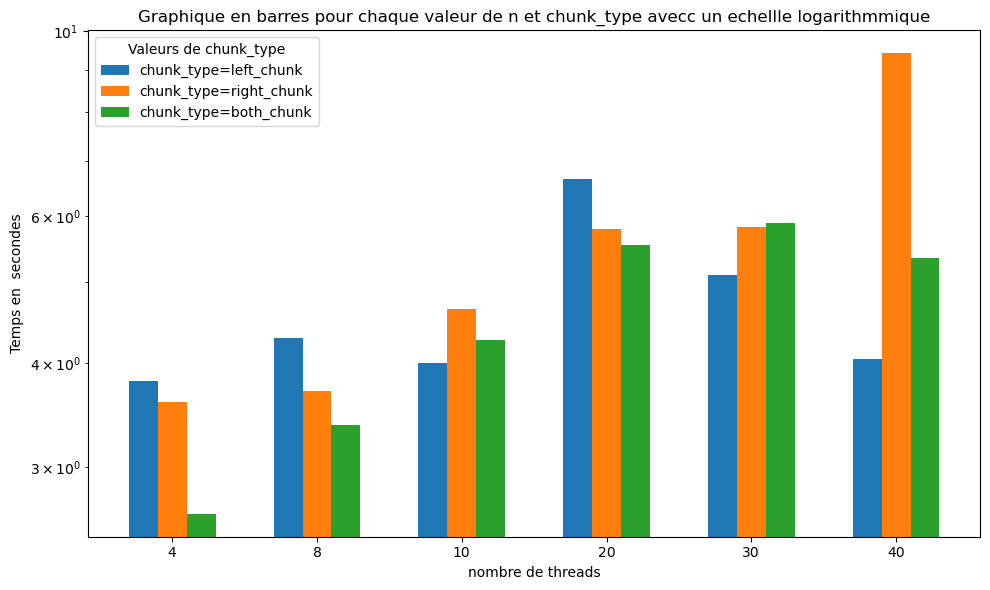

In [57]:
plt.figure(figsize=(10, 6))
df = pd.DataFrame(data_threading)
# Largeur des barres
bar_width = 0.2

# Positions des barres pour chaque groupe de `n`
positions = np.arange(len(df['n'].unique()))

# Boucle sur les valeurs de `chunk_type` pour tracer les barres
for i, a_value in enumerate(df['chunk_type'].unique()):
    # Filtrer les données pour chaque valeur de `chunk_type`
    subset = df[df['chunk_type'] == a_value]
    # Tracer les barres pour cette valeur de `chunk_type`
    plt.bar(positions + i * bar_width, subset['time'], width=bar_width, label=f'chunk_type={a_value}')

# Ajouter des labels et une légende
plt.xlabel('nombre de threads')
plt.ylabel('Temps en  secondes')
plt.title('Graphique en barres pour chaque valeur de n et chunk_type avecc un echellle logarithmmique')
plt.xticks(positions + bar_width, df['n'].unique())
plt.legend(title='Valeurs de chunk_type')
plt.yscale('log')
# Afficher le graphique
plt.tight_layout()
plt.show()

2. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **mutiprocessing** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$ en ne chargeant que les lignes et les colonnes nécessaires.

In [77]:
import multiprocessing
# Utiliser Manager pour partager les données entre les processus
manager = multiprocessing.Manager()
A = manager.dict({i: A_data[f"row_{i}"].astype(np.float64) for i in range(len(A_data.files))})
B = manager.dict({j: B_data[f"col_{j}"].astype(np.float64) for j in range(len(B_data.files))})

In [83]:
def calcul_chunk(debut, fin, queue, A, B, chunk_type):
    """Chaque processus calcule une partie des lignes de C et envoie le résultat via la queue"""
    C_partiel = np.zeros((fin - debut, len(B)))  
    
    if chunk_type == 'left_chunk':
        a_range = range(debut, fin)
        b_range = range(len(B))
        C_partiel = np.zeros((fin - debut, len(B))) 
        for i in a_range:
            for j in b_range:
                C_partiel[i - debut, j] = A[i] @ B[j]
    elif chunk_type == 'right_chunk':
        a_range = range(len(A))
        b_range = range(debut, fin)
        C_partiel = np.zeros((len(A), fin - debut)) 
        for i in a_range:
            for j in b_range:
                C_partiel[i, j - debut] = A[i] @ B[j]
    elif chunk_type == 'full_chunk':
        a_range = range(debut, fin)
        b_range = range(debut, fin)
        C_partiel = np.zeros((fin - debut, fin - debut)) 
        for i in a_range:
            for j in b_range:
                C_partiel[i - debut, j - debut] = A[i] @ B[j]

    queue.put((debut, C_partiel))  

In [84]:
%%time

chunk_type = 'left_chunk'

if __name__ == "__main__":
    num_processes = 4 
    step = len(A) // num_processes
    queue = multiprocessing.Queue()  # File d’attente pour récupérer les résultats
    processes = []

    debut_time = time.time()

    for i in range(num_processes):
        debut, fin = i * step, (i + 1) * step if i < num_processes - 1 else len(A)
        p = multiprocessing.Process(target=calcul_chunk, args=(debut, fin, queue, A, B, chunk_type))
        processes.append(p)
        p.start()

    C_mp = np.zeros((len(A), len(B)))

    for _ in processes:
        debut, chunk = queue.get()
        C_mp[debut:debut + chunk.shape[0], :] = chunk  

    for p in processes:
        p.join()

    end_time = time.time()
    print(f"Temps d'exécution Multiprocessing : {end_time - debut_time:.4f} sec")
    print("Extrait de C (Multiprocessing):\n", C_mp[:3, :3])


Temps d'exécution Multiprocessing : 1.8117 sec
Extrait de C (Multiprocessing):
 [[250503. 249939. 248864.]
 [250745. 248935. 250621.]
 [248384. 247606. 249230.]]
CPU times: user 4.82 ms, sys: 90.1 ms, total: 95 ms
Wall time: 1.81 s


3.Comparer les temps de restitution des différentes implémentations en variant le nombre de workers.

In [87]:
#TODO

data_multi_processing = {'n': [], 'chunk_type': [], 'time': []}
chunk_types = ["left_chunk", "right_chunk", "both_chunk"]

num_processes = [4, 8, 10, 20, 30, 40]

for n in num_processes:
    for chunk_type in chunk_types:
        step = len(A) // n
        queue = multiprocessing.Queue()  # File d’attente pour récupérer les résultats
        processes = []

        debut_time = time.time()

        for i in range(n):
            debut, fin = i * step, (i + 1) * step if i < n - 1 else len(A)
            p = multiprocessing.Process(target=calcul_chunk, args=(debut, fin, queue, A, B, chunk_type))
            processes.append(p)
            p.start()

        C_mp = np.zeros((len(A), len(B)))
        
        for _ in processes:
            debut, chunk = queue.get()
            if chunk_type == 'left_chunk':
                C_mp[debut:debut + chunk.shape[0], :] = chunk
            elif chunk_type == 'right_chunk':
                C_mp[:, debut:debut + chunk.shape[1]] = chunk
            elif chunk_type == 'full_chunk':
                C_mp[debut:debut + chunk.shape[0], debut:debut + chunk.shape[1]] = chunk
        for p in processes:
            p.join()

        end_time = time.time()
         
		 
        data_multi_processing['n'].append(n)
        data_multi_processing['chunk_type'].append(chunk_type)
        data_multi_processing['time'].append(time.time()-start_time)

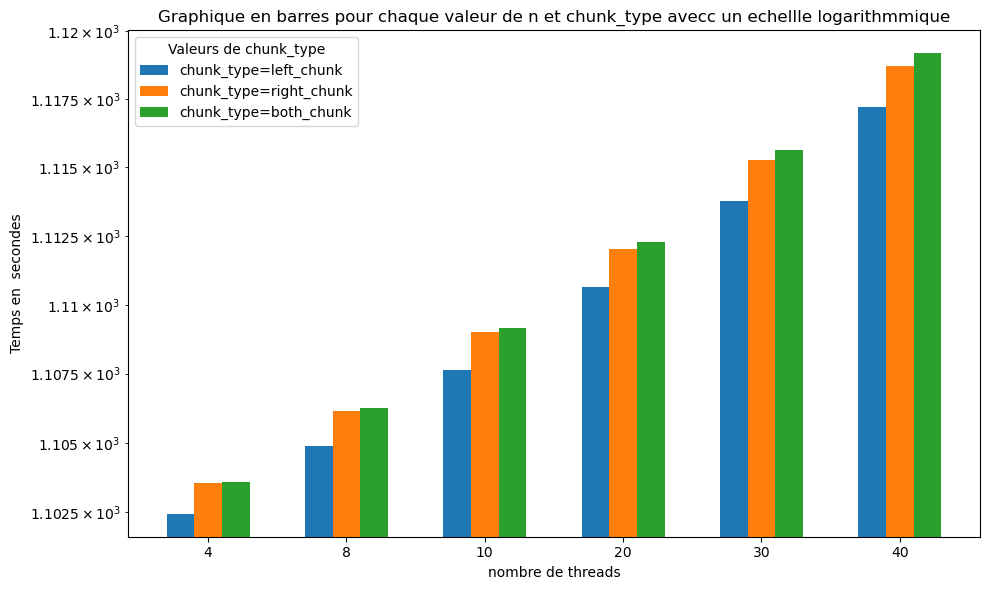

In [88]:
plt.figure(figsize=(10, 6))
df = pd.DataFrame(data_multi_processing)
# Largeur des barres
bar_width = 0.2

# Positions des barres pour chaque groupe de `n`
positions = np.arange(len(df['n'].unique()))

# Boucle sur les valeurs de `chunk_type` pour tracer les barres
for i, a_value in enumerate(df['chunk_type'].unique()):
    # Filtrer les données pour chaque valeur de `chunk_type`
    subset = df[df['chunk_type'] == a_value]
    # Tracer les barres pour cette valeur de `chunk_type`
    plt.bar(positions + i * bar_width, subset['time'], width=bar_width, label=f'chunk_type={a_value}')

# Ajouter des labels et une légende
plt.xlabel('nombre de threads')
plt.ylabel('Temps en  secondes')
plt.title('Graphique en barres pour chaque valeur de n et chunk_type avecc un echellle logarithmmique')
plt.xticks(positions + bar_width, df['n'].unique())
plt.legend(title='Valeurs de chunk_type')
plt.yscale('log')
# Afficher le graphique
plt.tight_layout()
plt.show()